**[WIP] This is a draft re-write. The planning notes are found in `m4.2.md`.**

# Fitting Models

In the previous section we learned about parameters representing mathematical elements of data. One way to think of models are that they are collection of parameters.

In order to use models to learn about data we need to tweak the parameter values so that the model is the best representation of the data that it could be.

This is called **fitting** a model to data.

We fit a model by constructing a **cost function**. A cost function can be any function where higher values mean a poorer fit and lower values mean a better fit. 

Let us illustrate this by using a very simple and familiar single-parameter model: _the mean_. 


### The mean as a model 

Let us have a dataset, $X$. We wish to represent this dataset as best we can with a single parameter on the same arithmetic scale as the data: $\mu$.

We first define a cost function. Since $\mu$ is meant to be a single quantity that represents the data we want values that a further away to $\mu$ to have a higher cost. Since we don't want negative values we could square the error, this will also have the added benefit of penalising higher errors more harshly that lower errors. We can sum all the **squared errors** of each data point from $\mu$ to get a single value that we could minimise. 

$$\sum (X-\mu)^2$$ 

However, this value is in squared error units, which is unintuitive. To keep the cost function in the units of the data we can take the average then take the square root. This gives us a common cost function, **root-mean-squared-error** (RMSE):

$$\sqrt{\frac{1}{n}\sum (X-\mu)^2}$$

Essentially, we fit this model by trying different predictions for $\mu$, calculating the cost, and selecting the value of $\mu$ that has the minimum cost.

In this case the minimum of this cost function corresponds exactly to the mean (with some sampling variability).

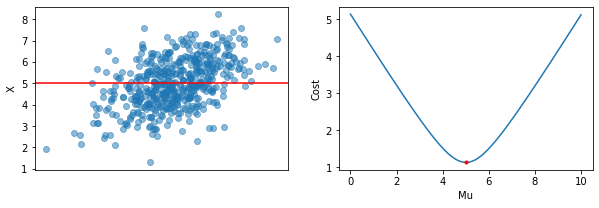

Mean: 5.009398391838773, Mu: 5.01


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

### generate fake data.
n = 500
b0 = 2
b1 = .3
var = norm.rvs(10,2,n)
stdev = 1
data = np.array([norm.rvs(b0+b1*x,stdev,1) for x in var])


### set predictions for mu
mu = np.linspace(0,10,10000)

### calculate costs
def cost(X, mu):
    return np.sqrt(np.mean((X-mu)**2))

costs = [cost(data, m) for m in mu]


fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].scatter(var,data, alpha=.5)
ax[0].set_ylabel('X')
ax[0].set_xticks([])
ax[0].axhline(np.mean(data),c='red')
ax[1].plot(mu,costs)
ax[1].plot(mu[np.argmin(costs)], min(costs), '.r')
ax[1].set_ylabel('Cost')
ax[1].set_xlabel('Mu')
plt.show()

print(f"Mean: {np.mean(data)}, Mu: {round(mu[np.argmin(costs)],2)}")

The mean is a poor model since it predicts the same value each time whereas the data is clearly represented by a range of values.

Perhaps the most common probablistic models is modelling the data points as coming from a _[normal distribution]_. A normal distribution, or gaussian distribution arises in cases where a continuous random variable has symetrical variability around a mean.

We fit a normal distribution to our data in a similar way to our previous example: we find the parameter values that are demonstrably best with respect to some cost function.

A common cost function for fitting probability distributions is the **likelihood**. Simply put, a likelihood of a single data point is the probability of that data point occuring given a probability distribution with certain parameters. The combined likelihood of a dataset is each individual likelihood multiplied together. A common fitting technique is to find the **maximum likelihood** of a dataset. 

```{note}
In practice getting the combined likelihood of a dataset is computationally infeasible (since the multiplied numbers are very small), so the log-likelihood is taken so that we can sum across the datapoints. Further, taking the _negative_ log-likihood allows us to use _minimisation_ algorithms. So, when you read _maximum likelihood estimation_ what the authors are normally talking about is _minimising the negative log-likelihood_. 
```

The log-likelihood is illustrated below with our previous fake dataset. To make the illustration simpler we have fixed the guassian variance parameter.

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


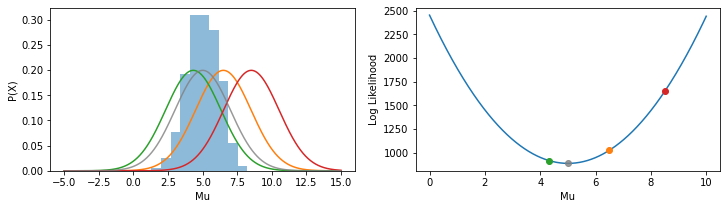

In [41]:
colors = ['C1','C2','C3'] #https://matplotlib.org/stable/users/dflt_style_changes.html
sigma = 2
n = 1000
mu = np.linspace(0,10,1000)
test_range = np.linspace(-5,15,10000)

likelihoods = np.array([np.multiply.reduce(norm.pdf(data, loc=m, scale=sigma)) for m in mu])
print(likelihoods[:5]) #all zeros because the values are so small

# so we take the negative log-likelihood .
logliks = np.array([np.sum(-norm.logpdf(data, loc=m, scale=sigma)) for m in mu])

fig, axes = plt.subplots(1,2, figsize=(12,3))

axes[0].hist(data, density=True, alpha=.5)
axes[0].set_ylabel('P(X)')
axes[0].set_xlabel('Mu')
axes[1].plot(mu, logliks)
axes[1].set_ylabel('Log Likelihood')
axes[1].set_xlabel('Mu')


# calculate example gaussians
mu_index = np.random.randint(n, size=3)
for (i, mu_i) in enumerate(mu_index):
    axes[0].plot(test_range, norm.pdf(test_range, loc=mu[mu_i], scale=sigma), color=colors[i])
    axes[1].plot(mu[mu_i],logliks[mu_i], 'o', color=colors[i])
    
# plot minimum log-lik (maximum likeilhood)
mu_min = mu[np.argmin(logliks)]
axes[0].plot(test_range, norm.pdf(test_range, loc=mu_min, scale=sigma), color='grey', alpha = .8)
axes[1].plot(mu_min, min(logliks), 'o', color='grey', alpha = .8)

plt.show()

**Plan for remainder**:

## Modelling relationships: Regression. 

Most RQs are interested in modelling relationships between variables. Instead of modelling directly the parameters of a distribution we can make the parameters dependent on on other variables. 

The simplest method of modelling relationships is to assign a model parameter for each input variable that you want to consider. 

More complex models but from adding in more variables and mathematically specifying the nature of the relationship between variables (e.g. interactions). 

Each input to your model, and it's associated parameter, called _coefficients_ can be thought of as a mini-hypothesis: given that I know all the other inputs to the model, what how much does this input contribute to the model? 

How many parameters?

It depends what you are interested in and what you want to learn. 

With enough parameters you can fit anything. But the model will not generalise well. We could just be fitting to noise.

(Bishop toy example), can show some plots from [here]( https://mantas.info/wp/wp-content/uploads/learn/curve-over-fitting.html)


### From linear regression to logistic regression.

The data considered so far deal with a continuous outcome variable, or a normal distribution. 

We have dichotomised our variable. 

Logistic regression is conceptrually similar in that we predict a parameter of a distribution, only this time it is a bernouilli distribution.

We obtain category classes by making the assumption that if the mean of the bernouilli distribution is below X. We class the prediction as Y. 

We will step through the development at the beginning of the next section.

[qu: how much of the logistic regression dev in the next section do we include here?]
